
=== Initial Network ===
Initial prediction: [0.756]
Initial loss: 0.029768

=== Gradients ===
dense_14/kernel:0:
[[-0.01464 -0.01952]]
dense_14/bias:0:
[-0.14640002 -0.19520001]
dense_15/kernel:0:
[[-0.07808001]
 [-0.25376   ]]
dense_15/bias:0:
[-0.48800004]


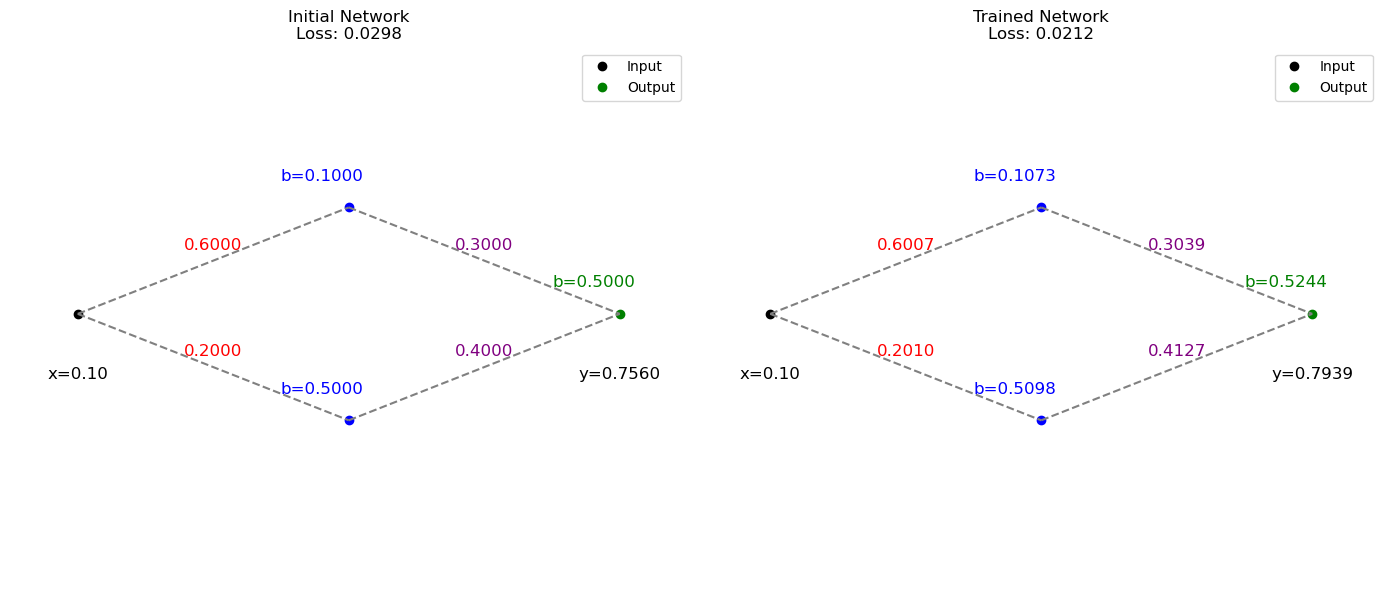


=== Updated Weights and Biases ===

Layer 1 (Input → Hidden):
Weights:
[[0.600732 0.200976]]
Biases:
[0.10732 0.50976]

Layer 2 (Hidden → Output):
Weights:
[[0.30390403]
 [0.41268802]]
Biases:
[0.5244]

=== Final Results ===
Final prediction: [0.7939373]
Final loss: 0.021231


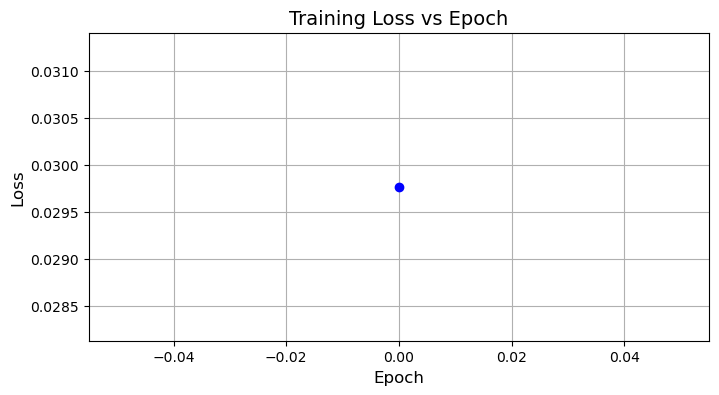

In [9]:
# Example 1

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
import logging

# Suppress TensorFlow warnings
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)

# Input values (only one input now)
x = np.array([[0.1]], dtype=np.float32)
y_true = np.array([1], dtype=np.float32)

# Store initial weights
initial_weights = {
    'layer1': {'weights': np.array([[0.6, 0.2]], dtype=np.float32),
               'biases': np.array([0.1, 0.5], dtype=np.float32)},
    'layer2': {'weights': np.array([[0.3], [0.4]], dtype=np.float32),
               'biases': np.array([0.5], dtype=np.float32)}
}

# Build model
model = Sequential([
    Dense(2, input_dim=1, activation='relu', use_bias=True),
    Dense(1, activation='relu', use_bias=True)
])

# Set initial weights
model.layers[0].set_weights([initial_weights['layer1']['weights'], 
                             initial_weights['layer1']['biases']])
model.layers[1].set_weights([initial_weights['layer2']['weights'], 
                             initial_weights['layer2']['biases']])

# Compile
# model.compile(optimizer=SGD(learning_rate=0.1), 
#               loss='mean_squared_error')
def sse(y_true, y_pred):
    return 0.5 * tf.reduce_sum(tf.square(y_true - y_pred))
model.compile(optimizer=SGD(learning_rate=0.1), loss=sse)

# Get initial predictions and loss
with tf.device('/CPU:0'):
    initial_y_pred = model(x, training=False)
    initial_predictions = initial_y_pred.numpy()
    initial_loss = model.evaluate(x, y_true, verbose=0)

# Visualization function
def draw_mlp_comparison(initial_weights, updated_weights, initial_preds, final_preds, init_loss, final_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    input_coord = (0.1, 0.5)
    hidden_coords = [(0.5, 0.7), (0.5, 0.3)]
    output_coord = (0.9, 0.5)
    
    ax1.set_title(f"Initial Network\nLoss: {init_loss:.4f}", fontsize=12)
    plot_network(ax1, input_coord, hidden_coords, output_coord,
                initial_weights['layer1']['weights'], 
                initial_weights['layer1']['biases'],
                initial_weights['layer2']['weights'], 
                initial_weights['layer2']['biases'],
                x, initial_preds)
    
    ax2.set_title(f"Trained Network\nLoss: {final_loss:.4f}", fontsize=12)
    plot_network(ax2, input_coord, hidden_coords, output_coord,
                updated_weights['layer1']['weights'], 
                updated_weights['layer1']['biases'],
                updated_weights['layer2']['weights'], 
                updated_weights['layer2']['biases'],
                x, final_preds)
    
    plt.tight_layout()
    plt.show()

def plot_network(ax, input_coord, hidden_coords, output_coord, 
                 w1, b1, w2, b2, input_vals, predictions):
    ax.plot(*input_coord, 'o', color='black', label='Input')
    ax.text(input_coord[0], input_coord[1]-0.1, 
            f"x={input_vals[0][0]:.2f}", ha='center', va='top', fontsize=12)
    
    for i, (hx, hy) in enumerate(hidden_coords):
        ax.plot(hx, hy, 'o', color='blue')
    
    ax.plot(*output_coord, 'o', color='green', label='Output')
    ax.text(output_coord[0], output_coord[1]-0.1, 
            f"y={predictions[0][0]:.4f}", ha='center', va='top', fontsize=12)
    
    for i, (hx, hy) in enumerate(hidden_coords):
        ax.plot([input_coord[0], hx], [input_coord[1], hy], 
                color='gray', linestyle='--')
        mx, my = (input_coord[0] + hx)/2, (input_coord[1] + hy)/2
        ax.text(mx, my + 0.02, f"{w1[0][i]:.4f}", fontsize=12, ha='center', color='red')
    
    for i, (hx, hy) in enumerate(hidden_coords):
        ax.plot([hx, output_coord[0]], [hy, output_coord[1]], 
                color='gray', linestyle='--')
        mx, my = (hx + output_coord[0])/2, (hy + output_coord[1])/2
        ax.text(mx, my + 0.02, f"{w2[i][0]:.4f}", fontsize=12, ha='center', color='purple')
    
    for i, (hx, hy) in enumerate(hidden_coords):
        ax.text(hx - 0.1, hy + 0.05, f"b={b1[i]:.4f}", fontsize=12, color='blue')
    ax.text(output_coord[0] - 0.1, output_coord[1] + 0.05, f"b={b2[0]:.4f}", fontsize=12, color='green')
    
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    ax.legend(loc='upper right')

# Show initial network info
print("\n=== Initial Network ===")
print(f"Initial prediction: {initial_predictions.flatten()}")
print(f"Initial loss: {initial_loss:.6f}")

# === Compute and print gradients manually ===
print("\n=== Gradients ===")
with tf.GradientTape() as tape:
    y_pred = model(x)
    loss_value = tf.keras.losses.mean_squared_error(y_true, y_pred)
grads = tape.gradient(loss_value, model.trainable_variables)
for var, grad in zip(model.trainable_variables, grads):
    print(f"{var.name}:\n{grad.numpy()}")

# Train model
history = model.fit(x, y_true, epochs=1, verbose=0)

# Get updated weights and predictions
with tf.device('/CPU:0'):
    final_y_pred = model(x, training=False)
    final_predictions = final_y_pred.numpy()
    final_loss = model.evaluate(x, y_true, verbose=0)

updated_weights = {
    'layer1': {'weights': model.layers[0].get_weights()[0],
               'biases': model.layers[0].get_weights()[1]},
    'layer2': {'weights': model.layers[1].get_weights()[0],
               'biases': model.layers[1].get_weights()[1]}
}

# Show comparison
draw_mlp_comparison(initial_weights, updated_weights, 
                    initial_predictions, final_predictions,
                    initial_loss, final_loss)

# === Print Updated Weights and Biases ===
print("\n=== Updated Weights and Biases ===")

w1, b1 = model.layers[0].get_weights()
print("\nLayer 1 (Input → Hidden):")
print(f"Weights:\n{w1}")
print(f"Biases:\n{b1}")

w2, b2 = model.layers[1].get_weights()
print("\nLayer 2 (Hidden → Output):")
print(f"Weights:\n{w2}")
print(f"Biases:\n{b2}")

# Final results
print("\n=== Final Results ===")
print(f"Final prediction: {final_predictions.flatten()}")
print(f"Final loss: {final_loss:.6f}")

# Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], 'b-o')
plt.title('Training Loss vs Epoch', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True)
plt.show()





=== Initial Network ===
Initial predictions: [0.756 0.782]
Initial loss: 0.053530


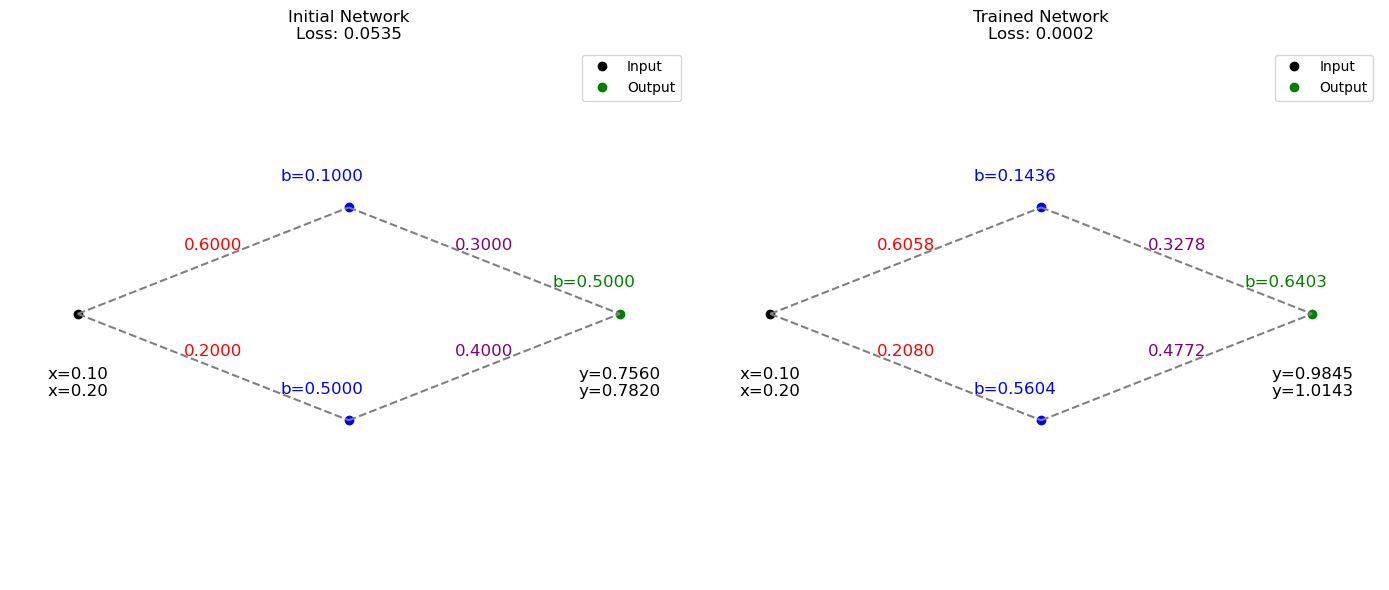


=== Updated Weights and Biases ===

Layer 1 (Input → Hidden):
Weights:
[[0.60583985 0.20804621]]
Biases:
[0.1436223  0.56036353]

Layer 2 (Hidden → Output):
Weights:
[[0.3277885 ]
 [0.47723007]]
Biases:
[0.6402607]

=== Final Results ===
Final predictions: [0.9845481 1.0143354]
Final loss: 0.000222


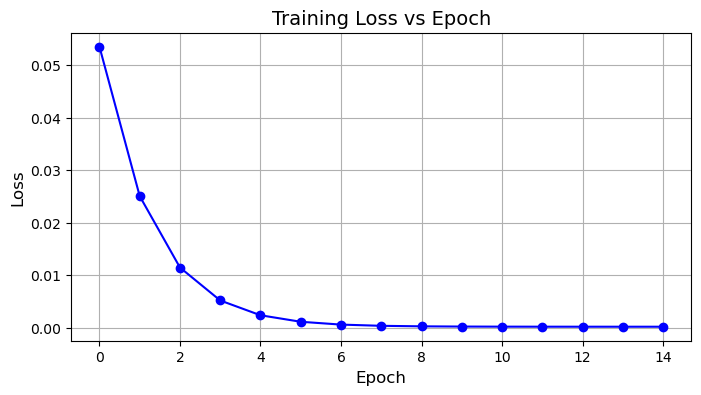

In [4]:
# Example 2

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
import logging


# Suppress TensorFlow warnings
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)

# Input values
x = np.array([[0.1], [0.2]], dtype=np.float32)
y_true = np.array([1, 1], dtype=np.float32)

# Store initial weights
initial_weights = {
    'layer1': {'weights': np.array([[0.6, 0.2]], dtype=np.float32),
               'biases': np.array([0.1, 0.5], dtype=np.float32)},
    'layer2': {'weights': np.array([[0.3], [0.4]], dtype=np.float32),
               'biases': np.array([0.5], dtype=np.float32)}
}

# Build model
model = Sequential([
    Dense(2, input_dim=1, activation='relu', use_bias=True),
    Dense(1, activation='relu', use_bias=True)
])

# Set initial weights
model.layers[0].set_weights([initial_weights['layer1']['weights'], 
                            initial_weights['layer1']['biases']])
model.layers[1].set_weights([initial_weights['layer2']['weights'], 
                            initial_weights['layer2']['biases']])

# Compile
# model.compile(optimizer=SGD(learning_rate=0.1), 
#               loss='mean_squared_error')
def sse(y_true, y_pred):
    return 0.5 * tf.reduce_sum(tf.square(y_true - y_pred))
model.compile(optimizer=SGD(learning_rate=0.1), loss=sse)

# Get initial predictions and loss
with tf.device('/CPU:0'):
    initial_y_pred = model(x, training=False)
    initial_predictions = initial_y_pred.numpy()
    initial_loss = model.evaluate(x, y_true, verbose=0)

# Visualization function
def draw_mlp_comparison(initial_weights, updated_weights, initial_preds, final_preds, init_loss, final_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Common coordinates
    input_coord = (0.1, 0.5)
    hidden_coords = [(0.5, 0.7), (0.5, 0.3)]
    output_coord = (0.9, 0.5)
    
    # Plot initial network
    ax1.set_title(f"Initial Network\nLoss: {init_loss:.4f}", fontsize=12)
    plot_network(ax1, input_coord, hidden_coords, output_coord,
                initial_weights['layer1']['weights'], 
                initial_weights['layer1']['biases'],
                initial_weights['layer2']['weights'], 
                initial_weights['layer2']['biases'],
                x, initial_preds)
    
    # Plot updated network
    ax2.set_title(f"Trained Network\nLoss: {final_loss:.4f}", fontsize=12)
    plot_network(ax2, input_coord, hidden_coords, output_coord,
                updated_weights['layer1']['weights'], 
                updated_weights['layer1']['biases'],
                updated_weights['layer2']['weights'], 
                updated_weights['layer2']['biases'],
                x, final_preds)
    
    plt.tight_layout()
    plt.show()

def plot_network(ax, input_coord, hidden_coords, output_coord, 
                w1, b1, w2, b2, input_vals, predictions):
    # Plot neurons with values
    ax.plot(*input_coord, 'o', color='black', label='Input')
    ax.text(input_coord[0], input_coord[1]-0.1, 
           f"x={input_vals[0][0]:.2f}\nx={input_vals[1][0]:.2f}", 
           ha='center', va='top', fontsize=12)
    
    for i, (hx, hy) in enumerate(hidden_coords):
        ax.plot(hx, hy, 'o', color='blue')
    
    ax.plot(*output_coord, 'o', color='green', label='Output')
    ax.text(output_coord[0], output_coord[1]-0.1, 
           f"y={predictions[0][0]:.4f}\ny={predictions[1][0]:.4f}", 
           ha='center', va='top', fontsize=12)
    
    # Input to Hidden connections
    for i, (hx, hy) in enumerate(hidden_coords):
        ax.plot([input_coord[0], hx], [input_coord[1], hy], 
                color='gray', linestyle='--')
        mx, my = (input_coord[0] + hx)/2, (input_coord[1] + hy)/2
        ax.text(mx, my + 0.02, f"{w1[0][i]:.4f}", 
               fontsize=12, ha='center', color='red')
    
    # Hidden to Output connections
    for i, (hx, hy) in enumerate(hidden_coords):
        ax.plot([hx, output_coord[0]], [hy, output_coord[1]], 
                color='gray', linestyle='--')
        mx, my = (hx + output_coord[0])/2, (hy + output_coord[1])/2
        ax.text(mx, my + 0.02, f"{w2[i][0]:.4f}", 
               fontsize=12, ha='center', color='purple')
    
    # Bias annotations
    for i, (hx, hy) in enumerate(hidden_coords):
        ax.text(hx - 0.1, hy + 0.05, f"b={b1[i]:.4f}", 
               fontsize=12, color='blue')
    ax.text(output_coord[0] - 0.1, output_coord[1] + 0.05, f"b={b2[0]:.4f}", 
           fontsize=12, color='green')
    
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    ax.legend(loc='upper right')

# Show initial network info
print("\n=== Initial Network ===")
print(f"Initial predictions: {initial_predictions.flatten()}")
print(f"Initial loss: {initial_loss:.6f}")

# Train model
history = model.fit(x, y_true, epochs=15, verbose=0)

# Get updated weights and predictions
with tf.device('/CPU:0'):
    final_y_pred = model(x, training=False)
    final_predictions = final_y_pred.numpy()
    final_loss = model.evaluate(x, y_true, verbose=0)

updated_weights = {
    'layer1': {'weights': model.layers[0].get_weights()[0],
               'biases': model.layers[0].get_weights()[1]},
    'layer2': {'weights': model.layers[1].get_weights()[0],
               'biases': model.layers[1].get_weights()[1]}
}

# Show comparison
draw_mlp_comparison(initial_weights, updated_weights, 
                   initial_predictions, final_predictions,
                   initial_loss, final_loss)


# === Print Updated Weights and Biases ===
print("\n=== Updated Weights and Biases ===")

# Layer 1
w1, b1 = model.layers[0].get_weights()
print("\nLayer 1 (Input → Hidden):")
print(f"Weights:\n{w1}")
print(f"Biases:\n{b1}")

# Layer 2
w2, b2 = model.layers[1].get_weights()
print("\nLayer 2 (Hidden → Output):")
print(f"Weights:\n{w2}")
print(f"Biases:\n{b2}")

# Final results
print("\n=== Final Results ===")
print(f"Final predictions: {final_predictions.flatten()}")
print(f"Final loss: {final_loss:.6f}")

# Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], 'b-o')
plt.title('Training Loss vs Epoch', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True)
plt.show()

1/1 [==============================] - 0s 21ms/step - loss: 9.0591e-05


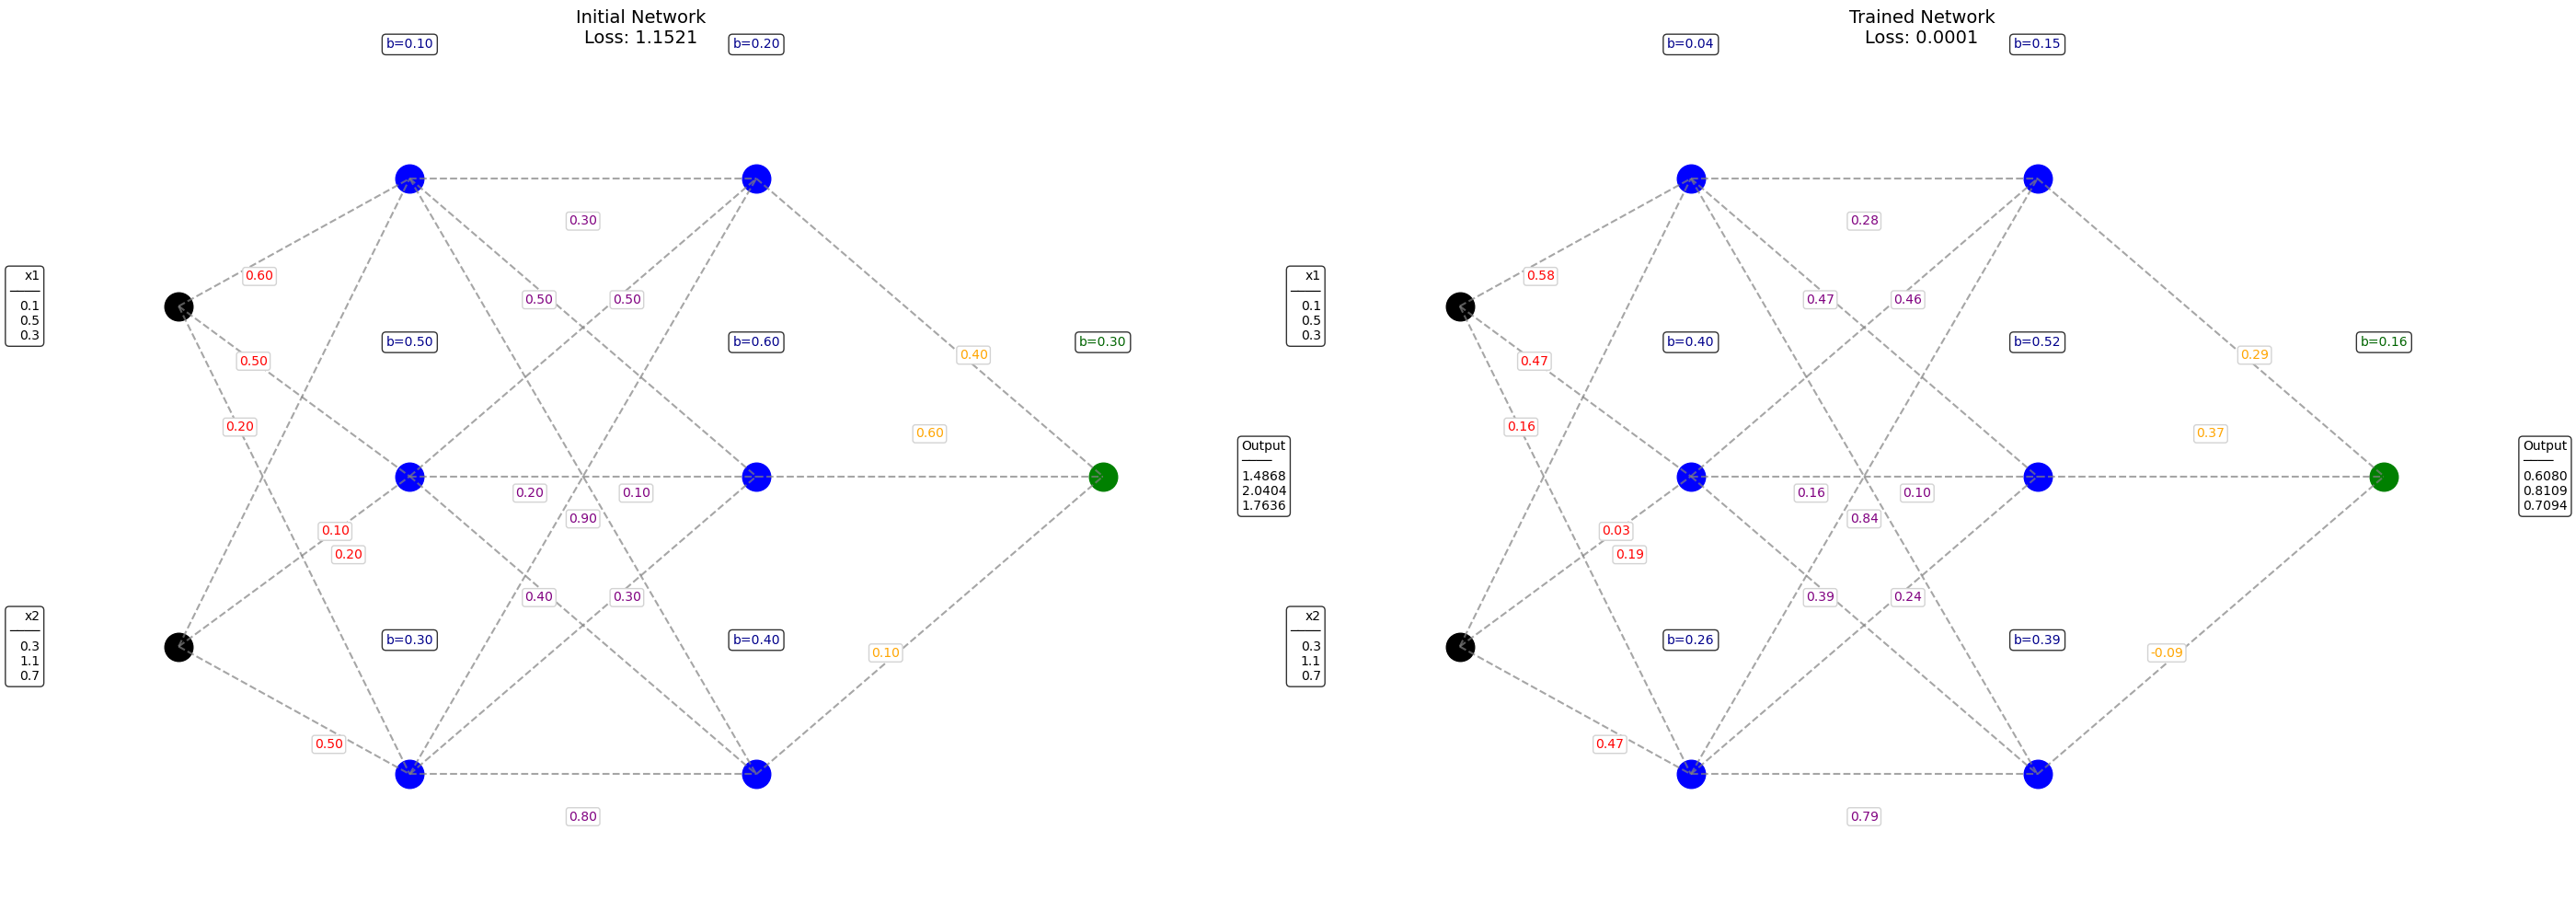

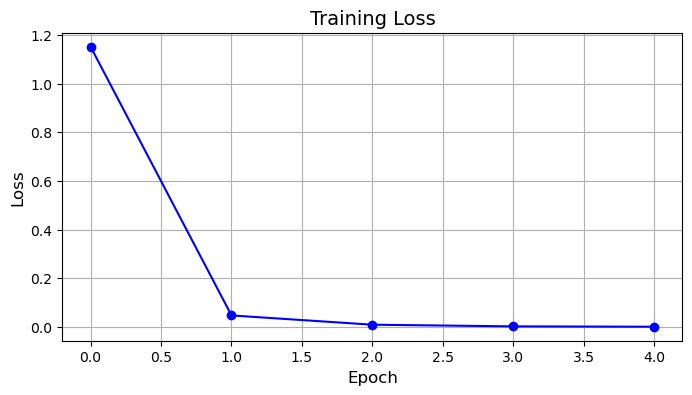

In [1]:
# Example 3

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
import logging

# Suppress TensorFlow warnings
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)

# ===== Input data (2 features, 3 samples) =====
x = np.array([
    [0.1, 0.3],  # Sample 1
    [0.5, 1.1],  # Sample 2
    [0.3, 0.7]   # Sample 3
], dtype=np.float32)

y_true = np.array([0.6, 0.8, 0.7], dtype=np.float32)

# ===== Initial weights =====
initial_weights = {
    'layer1': {'weights': np.array([[0.6, 0.5, 0.2], [0.2, 0.1, 0.5]], dtype=np.float32),
               'biases': np.array([0.1, 0.5, 0.3], dtype=np.float32)},
    'layer2': {'weights': np.array([[0.3, 0.5, 0.1], [0.5, 0.9, 0.4], [0.2, 0.3, 0.8]], dtype=np.float32),
               'biases': np.array([0.2, 0.6, 0.4], dtype=np.float32)},
    'layer3': {'weights': np.array([[0.4], [0.6], [0.1]], dtype=np.float32),
               'biases': np.array([0.3], dtype=np.float32)}
}

# ===== Build Model =====
model = Sequential([
    Dense(3, input_dim=2, activation='relu', name='hidden1'),
    Dense(3, activation='relu', name='hidden2'),
    Dense(1, activation='relu', name='output')
])

# Set initial weights
model.layers[0].set_weights([initial_weights['layer1']['weights'], 
                            initial_weights['layer1']['biases']])
model.layers[1].set_weights([initial_weights['layer2']['weights'], 
                            initial_weights['layer2']['biases']])
model.layers[2].set_weights([initial_weights['layer3']['weights'], 
                            initial_weights['layer3']['biases']])

# Compile
model.compile(optimizer=SGD(learning_rate=0.05), 
              loss='mean_squared_error')

# Initial predictions
initial_predictions = model.predict(x)
initial_loss = model.evaluate(x, y_true, verbose=1)

# ===== Smart Visualization =====
def draw_mlp_comparison(initial_weights, updated_weights, initial_preds, final_preds, init_loss, final_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(28, 10))  # Wider figure
    
    # Increased horizontal spacing between layers
    input_coords = [(0.1, 0.7), (0.1, 0.3)]  # x1, x2 positions
    hidden1_coords = [(0.3, 0.85), (0.3, 0.5), (0.3, 0.15)]  # First hidden layer
    hidden2_coords = [(0.6, 0.85), (0.6, 0.5), (0.6, 0.15)]  # Second hidden layer
    output_coord = (0.9, 0.5)                 # Output
    
    # Plot initial network
    plot_network(ax1, input_coords, hidden1_coords, hidden2_coords, output_coord,
                initial_weights, x, initial_preds, f"Initial Network\nLoss: {init_loss:.4f}")
    
    # Plot updated network
    plot_network(ax2, input_coords, hidden1_coords, hidden2_coords, output_coord,
                updated_weights, x, final_preds, f"Trained Network\nLoss: {final_loss:.4f}")
    
    plt.tight_layout()
    plt.show()

def plot_network(ax, input_coords, hidden1_coords, hidden2_coords, output_coord, 
                 weights, input_vals, predictions, title):
    ax.set_title(title, fontsize=14)
    
    # ===== Nodes =====
    # Input nodes
    for i, (ix, iy) in enumerate(input_coords):
        ax.plot(ix, iy, 'o', color='black', markersize=22)
        # Input values (column format)
        sample_values = "\n".join([f"{sample[i]:.1f}" for sample in input_vals])
        ax.text(ix-0.12, iy, f"x{i+1}\n────\n{sample_values}", 
                ha='right', va='center', fontsize=10, 
                bbox=dict(facecolor='white', alpha=0.8, pad=0.3, boxstyle='round'))
    
    # Hidden layer 1
    for j, (hx, hy) in enumerate(hidden1_coords):
        ax.plot(hx, hy, 'o', color='blue', markersize=22)
        # Bias above node
        ax.text(hx, hy+0.15, f"b={weights['layer1']['biases'][j]:.2f}", 
               fontsize=10, color='darkblue', ha='center', va='bottom',
               bbox=dict(facecolor='white', alpha=0.8, pad=0.3, boxstyle='round'))
    
    # Hidden layer 2
    for j, (hx, hy) in enumerate(hidden2_coords):
        ax.plot(hx, hy, 'o', color='blue', markersize=22)
        # Bias above node
        ax.text(hx, hy+0.15, f"b={weights['layer2']['biases'][j]:.2f}", 
               fontsize=10, color='darkblue', ha='center', va='bottom',
               bbox=dict(facecolor='white', alpha=0.8, pad=0.3, boxstyle='round'))
    
    # Output node
    ax.plot(*output_coord, 'o', color='green', markersize=22)
    # Predictions (column format)
    pred_text = "\n".join([f"{pred[0]:.4f}" for pred in predictions])
    ax.text(output_coord[0]+0.12, output_coord[1], f"Output\n────\n{pred_text}", 
           ha='left', va='center', fontsize=10,
           bbox=dict(facecolor='white', alpha=0.8, pad=0.3, boxstyle='round'))
    # Output bias
    ax.text(output_coord[0], output_coord[1]+0.15, f"b={weights['layer3']['biases'][0]:.2f}", 
           fontsize=10, color='darkgreen', ha='center', va='bottom',
           bbox=dict(facecolor='white', alpha=0.8, pad=0.3, boxstyle='round'))
    
    # ===== Connections with Smart Weight Labels =====
    # Input → Hidden1 weights
    for i, (ix, iy) in enumerate(input_coords):
        for j, (hx, hy) in enumerate(hidden1_coords):
            ax.plot([ix, hx], [iy, hy], color='gray', linestyle='--', alpha=0.7)
            # Smart position based on connection direction
            angle = np.arctan2(hy-iy, hx-ix)
            offset_dist = 0.05  # Increased offset distance
            offset_x = offset_dist * np.sin(angle) * (1 if j%2 else -1)
            offset_y = offset_dist * np.cos(angle) * (1 if j%2 else -1)
            mx, my = (ix + hx)/2 + offset_x, (iy + hy)/2 + offset_y
            ax.text(mx, my, f"{weights['layer1']['weights'][i][j]:.2f}", 
                   fontsize=10, color='red', ha='center', va='center',
                   bbox=dict(facecolor='white', edgecolor='lightgray', boxstyle='round', pad=0.2))
    
    # Hidden1 → Hidden2 weights
    for i, (h1x, h1y) in enumerate(hidden1_coords):
        for j, (h2x, h2y) in enumerate(hidden2_coords):
            ax.plot([h1x, h2x], [h1y, h2y], color='gray', linestyle='--', alpha=0.7)
            # Smart position with alternating offsets
            angle = np.arctan2(h2y-h1y, h2x-h1x)
            offset_dist = 0.05  # Increased offset distance
            offset_x = offset_dist * np.sin(angle) * (1 if (i+j)%2 else -1)
            offset_y = offset_dist * np.cos(angle) * (1 if (i+j)%2 else -1)
            mx, my = (h1x + h2x)/2 + offset_x, (h1y + h2y)/2 + offset_y
            ax.text(mx, my, f"{weights['layer2']['weights'][i][j]:.2f}", 
                   fontsize=10, color='purple', ha='center', va='center',
                   bbox=dict(facecolor='white', edgecolor='lightgray', boxstyle='round', pad=0.2))
    
    # Hidden2 → Output weights
    for i, (hx, hy) in enumerate(hidden2_coords):
        ax.plot([hx, output_coord[0]], [hy, output_coord[1]], color='gray', linestyle='--', alpha=0.7)
        # Smart position with alternating offsets
        angle = np.arctan2(output_coord[1]-hy, output_coord[0]-hx)
        offset_dist = 0.05  # Increased offset distance
        offset_x = offset_dist * np.sin(angle) * (1 if i%2 else -1)
        offset_y = offset_dist * np.cos(angle) * (1 if i%2 else -1)
        mx, my = (hx + output_coord[0])/2 + offset_x, (hy + output_coord[1])/2 + offset_y
        ax.text(mx, my, f"{weights['layer3']['weights'][i][0]:.2f}", 
               fontsize=10, color='orange', ha='center', va='center',
               bbox=dict(facecolor='white', edgecolor='lightgray', boxstyle='round', pad=0.2))
    
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')

# ===== Training =====
history = model.fit(x, y_true, epochs=5, verbose=0)

# Get updated weights after training
updated_weights = {
    'layer1': {'weights': model.layers[0].get_weights()[0],
               'biases': model.layers[0].get_weights()[1]},
    'layer2': {'weights': model.layers[1].get_weights()[0],
               'biases': model.layers[1].get_weights()[1]},
    'layer3': {'weights': model.layers[2].get_weights()[0],
               'biases': model.layers[2].get_weights()[1]}
}

# Final predictions
final_predictions = model.predict(x)
final_loss = model.evaluate(x, y_true, verbose=1)

# Now visualize with both initial and updated weights
draw_mlp_comparison(initial_weights, updated_weights, 
                   initial_predictions, final_predictions,
                   initial_loss, final_loss)

# Training plot
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], 'b-o')
plt.title('Training Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True)
plt.show()

X:
[[0.1 0.3]
 [0.5 1.1]
 [0.3 0.7]]

W1:
[[0.6 0.5 0.2]
 [0.2 0.1 0.5]]

W2:
[[0.3 0.5 0.1]
 [0.5 0.9 0.4]
 [0.2 0.3 0.8]]

W3:
[[0.4]
 [0.6]
 [0.1]]

b1:
[0.1 0.5 0.3]

b2:
[0.2 0.6 0.4]

b3:
[0.3]
1/1 [==============================] - 0s 21ms/step - loss: 6.5903e-06


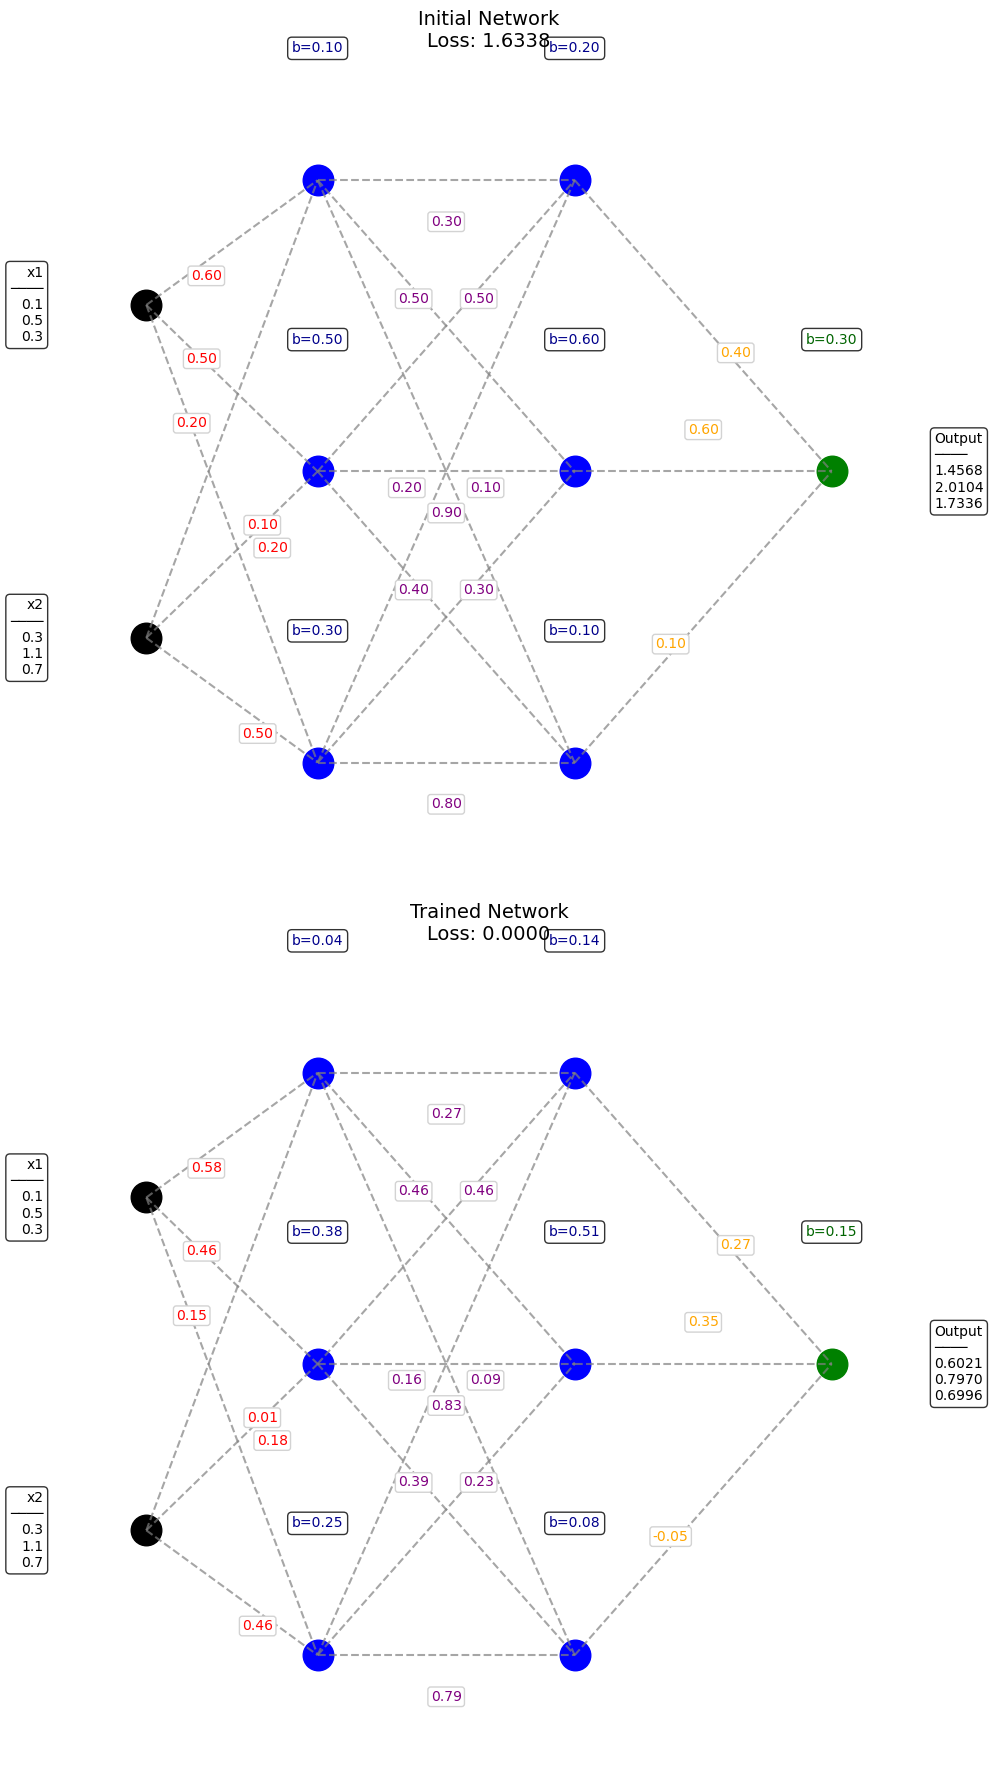

In [5]:
# Example 3
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
import logging

# Print the requested values
print("X:")
print(np.array([
    [0.1, 0.3],  # Sample 1
    [0.5, 1.1],  # Sample 2
    [0.3, 0.7]   # Sample 3
], dtype=np.float32))

print("\nW1:")
print(np.array([[0.6, 0.5, 0.2], [0.2, 0.1, 0.5]], dtype=np.float32))
print("\nW2:")
print(np.array([[0.3, 0.5, 0.1], [0.5, 0.9, 0.4], [0.2, 0.3, 0.8]], dtype=np.float32))
print("\nW3:")
print(np.array([[0.4], [0.6], [0.1]], dtype=np.float32))

print("\nb1:")
print(np.array([0.1, 0.5, 0.3], dtype=np.float32))
print("\nb2:")
print(np.array([0.2, 0.6, 0.4], dtype=np.float32))
print("\nb3:")
print(np.array([0.3], dtype=np.float32))

# Suppress TensorFlow warnings
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)

# ===== Input data (2 features, 3 samples) =====
x = np.array([
    [0.1, 0.3],  # Sample 1
    [0.5, 1.1],  # Sample 2
    [0.3, 0.7]   # Sample 3
], dtype=np.float32)

y_true = np.array([0.6, 0.8, 0.7], dtype=np.float32)

# ===== Initial weights =====
initial_weights = {
    'layer1': {'weights': np.array([[0.6, 0.5, 0.2], [0.2, 0.1, 0.5]], dtype=np.float32),
               'biases': np.array([0.1, 0.5, 0.3], dtype=np.float32)},
    'layer2': {'weights': np.array([[0.3, 0.5, 0.1], [0.5, 0.9, 0.4], [0.2, 0.3, 0.8]], dtype=np.float32),
               'biases': np.array([0.2, 0.6, 0.1], dtype=np.float32)},
    'layer3': {'weights': np.array([[0.4], [0.6], [0.1]], dtype=np.float32),
               'biases': np.array([0.3], dtype=np.float32)}
}

# ===== Build Model =====
model = Sequential([
    Dense(3, input_dim=2, activation='relu', name='hidden1'),
    Dense(3, activation='relu', name='hidden2'),
    Dense(1, activation='relu', name='output')
])

# Set initial weights
model.layers[0].set_weights([initial_weights['layer1']['weights'], 
                            initial_weights['layer1']['biases']])
model.layers[1].set_weights([initial_weights['layer2']['weights'], 
                            initial_weights['layer2']['biases']])
model.layers[2].set_weights([initial_weights['layer3']['weights'], 
                            initial_weights['layer3']['biases']])

# Compile
# model.compile(optimizer=SGD(learning_rate=0.05), 
#               loss='mean_squared_error')

def sse(y_true, y_pred):
    return 0.5 * tf.reduce_sum(tf.square(y_true - y_pred))
model.compile(optimizer=SGD(learning_rate=0.05), loss=sse)


# # Initial predictions
# initial_predictions = model.predict(x)
# initial_loss = model.evaluate(x, y_true, verbose=1)

# ===== Smart Visualization =====
def draw_mlp_comparison(initial_weights, updated_weights, initial_preds, final_preds, init_loss, final_loss):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 18))  # Adjusted to vertical layout
    
    # Increased horizontal spacing between layers
    input_coords = [(0.1, 0.7), (0.1, 0.3)]  # x1, x2 positions
    hidden1_coords = [(0.3, 0.85), (0.3, 0.5), (0.3, 0.15)]  # First hidden layer
    hidden2_coords = [(0.6, 0.85), (0.6, 0.5), (0.6, 0.15)]  # Second hidden layer
    output_coord = (0.9, 0.5)                 # Output
    
    # Plot initial network
    plot_network(ax1, input_coords, hidden1_coords, hidden2_coords, output_coord,
                initial_weights, x, initial_preds, f"Initial Network\nLoss: {init_loss:.4f}")
    
    # Plot updated network
    plot_network(ax2, input_coords, hidden1_coords, hidden2_coords, output_coord,
                updated_weights, x, final_preds, f"Trained Network\nLoss: {final_loss:.4f}")
    
    plt.tight_layout()
    plt.show()

def plot_network(ax, input_coords, hidden1_coords, hidden2_coords, output_coord, 
                 weights, input_vals, predictions, title):
    ax.set_title(title, fontsize=14)
    
    # ===== Nodes =====
    # Input nodes
    for i, (ix, iy) in enumerate(input_coords):
        ax.plot(ix, iy, 'o', color='black', markersize=22)
        # Input values (column format)
        sample_values = "\n".join([f"{sample[i]:.1f}" for sample in input_vals])
        ax.text(ix-0.12, iy, f"x{i+1}\n────\n{sample_values}", 
                ha='right', va='center', fontsize=10, 
                bbox=dict(facecolor='white', alpha=0.8, pad=0.3, boxstyle='round'))
    
    # Hidden layer 1
    for j, (hx, hy) in enumerate(hidden1_coords):
        ax.plot(hx, hy, 'o', color='blue', markersize=22)
        # Bias above node
        ax.text(hx, hy+0.15, f"b={weights['layer1']['biases'][j]:.2f}", 
               fontsize=10, color='darkblue', ha='center', va='bottom',
               bbox=dict(facecolor='white', alpha=0.8, pad=0.3, boxstyle='round'))
    
    # Hidden layer 2
    for j, (hx, hy) in enumerate(hidden2_coords):
        ax.plot(hx, hy, 'o', color='blue', markersize=22)
        # Bias above node
        ax.text(hx, hy+0.15, f"b={weights['layer2']['biases'][j]:.2f}", 
               fontsize=10, color='darkblue', ha='center', va='bottom',
               bbox=dict(facecolor='white', alpha=0.8, pad=0.3, boxstyle='round'))
    
    # Output node
    ax.plot(*output_coord, 'o', color='green', markersize=22)
    # Predictions (column format)
    pred_text = "\n".join([f"{pred[0]:.4f}" for pred in predictions])
    ax.text(output_coord[0]+0.12, output_coord[1], f"Output\n────\n{pred_text}", 
           ha='left', va='center', fontsize=10,
           bbox=dict(facecolor='white', alpha=0.8, pad=0.3, boxstyle='round'))
    # Output bias
    ax.text(output_coord[0], output_coord[1]+0.15, f"b={weights['layer3']['biases'][0]:.2f}", 
           fontsize=10, color='darkgreen', ha='center', va='bottom',
           bbox=dict(facecolor='white', alpha=0.8, pad=0.3, boxstyle='round'))
    
    # ===== Connections with Smart Weight Labels =====
    # Input → Hidden1 weights
    for i, (ix, iy) in enumerate(input_coords):
        for j, (hx, hy) in enumerate(hidden1_coords):
            ax.plot([ix, hx], [iy, hy], color='gray', linestyle='--', alpha=0.7)
            # Smart position based on connection direction
            angle = np.arctan2(hy-iy, hx-ix)
            offset_dist = 0.05  # Increased offset distance
            offset_x = offset_dist * np.sin(angle) * (1 if j%2 else -1)
            offset_y = offset_dist * np.cos(angle) * (1 if j%2 else -1)
            mx, my = (ix + hx)/2 + offset_x, (iy + hy)/2 + offset_y
            ax.text(mx, my, f"{weights['layer1']['weights'][i][j]:.2f}", 
                   fontsize=10, color='red', ha='center', va='center',
                   bbox=dict(facecolor='white', edgecolor='lightgray', boxstyle='round', pad=0.2))
    
    # Hidden1 → Hidden2 weights
    for i, (h1x, h1y) in enumerate(hidden1_coords):
        for j, (h2x, h2y) in enumerate(hidden2_coords):
            ax.plot([h1x, h2x], [h1y, h2y], color='gray', linestyle='--', alpha=0.7)
            # Smart position with alternating offsets
            angle = np.arctan2(h2y-h1y, h2x-h1x)
            offset_dist = 0.05  # Increased offset distance
            offset_x = offset_dist * np.sin(angle) * (1 if (i+j)%2 else -1)
            offset_y = offset_dist * np.cos(angle) * (1 if (i+j)%2 else -1)
            mx, my = (h1x + h2x)/2 + offset_x, (h1y + h2y)/2 + offset_y
            ax.text(mx, my, f"{weights['layer2']['weights'][i][j]:.2f}", 
                   fontsize=10, color='purple', ha='center', va='center',
                   bbox=dict(facecolor='white', edgecolor='lightgray', boxstyle='round', pad=0.2))
    
    # Hidden2 → Output weights
    for i, (hx, hy) in enumerate(hidden2_coords):
        ax.plot([hx, output_coord[0]], [hy, output_coord[1]], color='gray', linestyle='--', alpha=0.7)
        # Smart position with alternating offsets
        angle = np.arctan2(output_coord[1]-hy, output_coord[0]-hx)
        offset_dist = 0.05  # Increased offset distance
        offset_x = offset_dist * np.sin(angle) * (1 if i%2 else -1)
        offset_y = offset_dist * np.cos(angle) * (1 if i%2 else -1)
        mx, my = (hx + output_coord[0])/2 + offset_x, (hy + output_coord[1])/2 + offset_y
        ax.text(mx, my, f"{weights['layer3']['weights'][i][0]:.2f}", 
               fontsize=10, color='orange', ha='center', va='center',
               bbox=dict(facecolor='white', edgecolor='lightgray', boxstyle='round', pad=0.2))
    
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')

# ===== Training =====
# Initial predictions
initial_predictions = model.predict(x)
initial_loss = model.evaluate(x, y_true, verbose=1)

# ===== Training =====
history = model.fit(x, y_true, epochs=5, verbose=0)

# Get updated weights after training
updated_weights = {
    'layer1': {'weights': model.layers[0].get_weights()[0],
               'biases': model.layers[0].get_weights()[1]},
    'layer2': {'weights': model.layers[1].get_weights()[0],
               'biases': model.layers[1].get_weights()[1]},
    'layer3': {'weights': model.layers[2].get_weights()[0],
               'biases': model.layers[2].get_weights()[1]}
}

# Final predictions
final_predictions = model.predict(x)
final_loss = model.evaluate(x, y_true, verbose=1)

# Visualize Comparison
draw_mlp_comparison(initial_weights, updated_weights, initial_predictions, 
                    final_predictions, initial_loss, final_loss)


In [6]:
# Example 3 - Checking manual solution from the lecture

import numpy as np

# Inputs (3 samples, 2 features)
X = np.array([
    [0.1, 0.3],
    [0.5, 1.1],
    [0.3, 0.7]
])

# True output
y_true = np.array([
    [0.6],
    [0.8],
    [0.7]
])

# Initial Weights and biases
W1 = np.array([
    [0.6, 0.5, 0.2],
    [0.2, 0.1, 0.5]
])
b1 = np.array([0.1, 0.5, 0.3])

W2 = np.array([
    [0.3, 0.5, 0.1],
    [0.5, 0.9, 0.4],
    [0.2, 0.3, 0.8]
])
b2 = np.array([0.2, 0.6, 0.1])

W3 = np.array([
    [0.4],
    [0.6],
    [0.1]
])
b3 = np.array([0.3])

# Activation and derivative
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

# Print Initial Weights and Biases
print("Initial Weights and Biases:")
print("W1:\n", W1)
print("b1:", b1)
print("W2:\n", W2)
print("b2:", b2)
print("W3:\n", W3)
print("b3:", b3)

# Forward pass
Z1 = X @ W1 + b1
A1 = relu(Z1)

Z2 = A1 @ W2 + b2
A2 = relu(Z2)

Z3 = A2 @ W3 + b3
A3 = relu(Z3)

# Print Activations
print("\nActivations:")
print("A1:\n", A1)
print("A2:\n", A2)
print("A3:\n", A3)

# Loss (MSE)
loss = 0.5 * np.sum((A3 - y_true) ** 2)
print("\nMSE Loss:", loss)

# Deltas (Errors)
delta3 = (A3 - y_true) * relu_derivative(Z3)
delta2 = (delta3 @ W3.T) * relu_derivative(Z2)
delta1 = (delta2 @ W2.T) * relu_derivative(Z1)

print("\nDeltas:")
print("delta3:\n", delta3)
print("delta2:\n", delta2)
print("delta1:\n", delta1)

# Gradients
grad_W3 = A2.T @ delta3
grad_b3 = np.sum(delta3, axis=0)

grad_W2 = A1.T @ delta2
grad_b2 = np.sum(delta2, axis=0)

grad_W1 = X.T @ delta1
grad_b1 = np.sum(delta1, axis=0)

print("\nGradients:")
print("grad_W3:\n", grad_W3)
print("grad_b3:", grad_b3)
print("grad_W2:\n", grad_W2)
print("grad_b2:", grad_b2)
print("grad_W1:\n", grad_W1)
print("grad_b1:", grad_b1)

# Learning rate
lr = 0.05

# Update weights and biases
W1 -= lr * grad_W1
b1 -= lr * grad_b1

W2 -= lr * grad_W2
b2 -= lr * grad_b2

W3 -= lr * grad_W3
b3 -= lr * grad_b3

# Print Updated Weights and Biases
print("\nUpdated Weights and Biases:")
print("W1:\n", W1)
print("b1:", b1)
print("W2:\n", W2)
print("b2:", b2)
print("W3:\n", W3)
print("b3:", b3)


Initial Weights and Biases:
W1:
 [[0.6 0.5 0.2]
 [0.2 0.1 0.5]]
b1: [0.1 0.5 0.3]
W2:
 [[0.3 0.5 0.1]
 [0.5 0.9 0.4]
 [0.2 0.3 0.8]]
b2: [0.2 0.6 0.1]
W3:
 [[0.4]
 [0.6]
 [0.1]]
b3: [0.3]

Activations:
A1:
 [[0.22 0.58 0.47]
 [0.62 0.86 0.95]
 [0.42 0.72 0.71]]
A2:
 [[0.65  1.373 0.73 ]
 [1.006 1.969 1.266]
 [0.828 1.671 0.998]]
A3:
 [[1.4568]
 [2.0104]
 [1.7336]]

MSE Loss: 1.6337516799999996

Deltas:
delta3:
 [[0.8568]
 [1.2104]
 [1.0336]]
delta2:
 [[0.34272 0.51408 0.08568]
 [0.48416 0.72624 0.12104]
 [0.41344 0.62016 0.10336]]
delta1:
 [[0.368424 0.668304 0.291312]
 [0.520472 0.944112 0.411536]
 [0.444448 0.806208 0.351424]]

Gradients:
grad_W3:
 [[2.6304032]
 [5.2868096]
 [3.1893632]]
grad_b3: [3.1008]
grad_W2:
 [[0.5492224 0.8238336 0.1373056]
 [0.912832  1.369248  0.228208 ]
 [0.9145728 1.3718592 0.2286432]]
grad_b2: [1.24032 1.86048 0.31008]
grad_W1:
 [[0.4304128 0.7807488 0.3403264]
 [0.99416   1.80336   0.78608  ]]
grad_b1: [1.333344 2.418624 1.054272]

Updated Weights and Bi